# Финальный проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель **retention**. Напишите функцию для его подсчета.
2. Помимо этого, в компании **провели A/B** тестирование наборов аукционных предложений. На основе имеющихся данных определите, **какой набор можно считать лучшим** и **на основе каких метрик** стоит принять правильное решение.
3. **Предложите метрики** для оценки результатов последнего прошедшего тематического события в игре.

**Данные:**<br>

    problem1-reg_data.csv   – данные о времени регистрации
    problem1-auth_data.csv  – данные о времени захода пользователей в игру

In [99]:
import pandas as pd
import numpy as np
import datetime

import pingouin as pg
from scipy.stats import chi2_contingency

import requests 
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
sns.set(
        font_scale = 1,
        style = 'whitegrid',
        rc = {'figure.figsize': (12, 8)}
        )

### Задание 1

 ***Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).***

**1.1. Предварительный анализ данных (EDA)**

In [101]:
# Функция чтения данных с Яндекс Диска.
def YandexDisk_read_csv(public_url, sep):
    """
        Функция принимает два аргумента: ссылка на файл с Яндекс Диска и разделить данных в файле;
        получает загрузочную ссылку, как адрес на API Яндекс + ссылка на файл Яндекс Диска.
        По загрузочной ссылке возвращает датафрейм. 
        
                Параметры:
                        public_url - ссылка на файл с Яндекс Диска,
                        sep - разделить данных.
                        
                Возвращаемое значение:
                        pd.read_csv(download_url, sep=sep) - датафрейм.
    """
    # Фиксируем API Яндекс Диска.
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Формируем загрузочную ссылку:  базовый URL-адрес + ссылка на источник данных на Янденкс Диске.
    final_url = base_url + urlencode({'public_key': public_url})
    
    # Получаем доступ к данным по url.
    response = requests.get(final_url)
    
    # Декодируем в формат json и по ключу 'href' получаем доступ к прямой ссылке на данные.
    download_url = response.json()['href'] 
    
    return pd.read_csv(download_url, sep = sep) 

In [58]:
# Импортируем данные, используя функцию YandexDisk_read_csv.
reg = YandexDisk_read_csv('https://disk.yandex.com.am/d/JOHBZel5ICHuGg', sep=';')
auth = YandexDisk_read_csv('https://disk.yandex.com.am/d/9lCyKjtvqnJY0Q', sep = ';') 

Посмотрим на таблицы с данными.

In [59]:
reg.head(3)                                                                                                   

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [60]:
auth.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


Колонка с датой представлена в числовом формате. Приведем её к типу данных datetime и оставим только дату без времени, тип данных при этом не изменится.

In [66]:
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit = 's').dt.normalize()
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit = 's').dt.normalize()

In [52]:
reg.head(3)  

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3


In [53]:
auth.head(3)

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2


Посмотрим на общую информацию в таблицах.

In [54]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [55]:
auth.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   auth_ts  9601013 non-null  datetime64[ns]
 1   uid      9601013 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


Типы данных корректны, отсутствующих значений нет.<br> В таблице с регистрацией пользователей - 1 000 000 строк, в таблице с заходами в игру - 9 601 013 строк.

Проверим таблицы на наличие дубликатов.

In [56]:
reg.duplicated().sum()

0

In [57]:
auth.duplicated().sum()

0

Дубликаты в обоих таблицах отсутствуют.

Проверим наличие багов в данных: 
* есть ли пользователи, которые зарегистрировались не единожды? 
* есть ли пользователи, которые присутствовали в игре до регистрации?

In [58]:
# Найдем число уникальных пользователей в обоих таблицах.
print(f'Число уникальных пользователей при регистрации: {reg["uid"].nunique()}\n\
Число уникальных пользователей, заходивших в игру: {auth["uid"].nunique()}')

Число уникальных пользователей при регистрации: 1000000
Число уникальных пользователей, заходивших в игру: 1000000


Число уникальных пользователей в таблице регистрации совпадает с числом строк датафрейма. Следовательно пользователи, которые могли быть учтены в регистрации несколько раз, отсутствуют.<br>
Число уникальных значений идентично в обоих таблицах. Следовательно незарегистрированных пользователей в игре не было. 

**1.2. Расчет retention**

In [83]:
total = reg.merge(auth, on = 'uid')
total['Period'] = (total.auth_ts - total.reg_ts).dt.days
total['users_end_period'] = total.groupby(['reg_ts', 'auth_ts'])['uid'].transform('nunique')
total

,reg_ts,uid,auth_ts,Period,users_end_period
0,1998-11-18,1,1998-11-18,0,1
1,1999-07-22,2,1999-07-22,0,1
2,1999-07-22,2,1999-07-25,3,1
3,1999-07-22,2,1999-07-31,9,1
4,1999-07-22,2,1999-08-05,14,1
...,...,...,...,...,...
9601008,2020-09-23,1110618,2020-09-23,0,1048
9601009,2020-09-23,1110619,2020-09-23,0,1048
9601010,2020-09-23,1110620,2020-09-23,0,1048
9601011,2020-09-23,1110621,2020-09-23,0,1048


In [90]:
total.query('reg_ts == "1999-07-22"' and 'auth_ts == "1999-08-05"')

,reg_ts,uid,auth_ts,Period,users_end_period
4,1999-07-22,2,1999-08-05,14,1


In [96]:
min_date = reg.reg_ts.dt.date.min()
max_date = reg.reg_ts.dt.date.max()

print(f'[{min_date}, {max_date}]')
type(min_date)

[1998-11-18, 2020-09-23]


datetime.date

In [97]:
total.query('reg_ts >= @min_date & auth_ts <= @max_date')

,reg_ts,uid,auth_ts,Period,users_end_period
0,1998-11-18,1,1998-11-18,0,1
1,1999-07-22,2,1999-07-22,0,1
2,1999-07-22,2,1999-07-25,3,1
3,1999-07-22,2,1999-07-31,9,1
4,1999-07-22,2,1999-08-05,14,1
...,...,...,...,...,...
9601008,2020-09-23,1110618,2020-09-23,0,1048
9601009,2020-09-23,1110619,2020-09-23,0,1048
9601010,2020-09-23,1110620,2020-09-23,0,1048
9601011,2020-09-23,1110621,2020-09-23,0,1048


In [59]:
# Функция расчета retention игроков.
def retention_funс(df_reg, df_auth, first_date, last_date):
    """"
        Функция принимает две таблицы с данными о регистрации игроков и о времени захода пользователей в игру. 
        Функцию можно применять, как для всего периода, так и для части (сэмпла) данных. Для этого на вход подается
        ещё два параметра: дата начала рассматриваемого периода и дата конца.
        Функция возвращает таблицу, содержащую retention игроков по дням от даты регистрации игрока и визуализирует результат.
        
                Параметры:        
                        df_reg     - таблица с датами регистрации игроков
                        df_auth    - таблица с датами захода пользователей в игру
                        first_date - первоначальная дата для сэмпла 
                        last_date  - конечная дата для семпла
                        
                Возвращаемое значение:                
                        cohort     - таблица с расчетом retention по дням для игроков, которые объединяются в когорты 
                                     по дате регистрации
    """
    # Объединяем таблицы с регистрацией и заходами в игру в одну общую таблицу.    
    total = df_reg.merge(df_auth, on = 'uid')
    
    # Создаем колонку с разницей в днях от даты регистрации в игре до даты захода в игру. 
    # Эта колонка будет служить периодом для retention.
    total['Period'] = (total.auth_ts - total.reg_ts).dt.days
    
    # Выделим число пользователей на конец периода.
    total['users_end_period'] = total.groupby(['reg_ts', 'auth_ts'])['uid'].transform('nunique')
    
    # Выделим число пользователей на начало периода.
    total['users_start_period'] = total.groupby(['reg_ts'])['Period'].transform(lambda x: (x == 0).sum())
    
    # Рассчитаем retention.
    total['retention'] = (total.users_end_period / total.users_start_period).round(2)
    
    # Преобразуем параметры функции с датами из строкового типа в тип datetime с учетом определенного формата вывода.
    first_date = datetime.datetime.strptime(first_date, '%Y-%m-%d')
    last_date = datetime.datetime.strptime(last_date, '%Y-%m-%d')
    
    # Сформируем таблицу с кагортами, отфильтровав источник по заданному периоду.
    cohort = total.query('reg_ts >= @first_date & auth_ts <= @last_date')\
                  .pivot_table(index = 'reg_ts', columns = 'Period', values = 'retention')
    
    # Визуализируем результат при помощи тепловой карты.
        
    # Удаляем неинформативный столбец с нулевым периодом, что позволит 
    # корректно применить палитру к значениям retention в heatmap.
    cohort_visualization = cohort.copy().drop(columns = 0)
    
    # Преобразуем колонку с кагортами к более удобному формату вывода данных (только дата).
    cohort_visualization.index = cohort_visualization.index.date
    
    # Визуализация.
    ax = sns.heatmap(data = cohort_visualization, 
                     cmap = 'GnBu', 
                     annot = True, 
                     fmt = '.0%', 
                     cbar = True, 
                     linewidths = 0.5, 
                     square = True)
    ax.set_title('User Retention', fontsize = 15)
    ax.set_ylabel('Cohort')
    
    return cohort 

In [60]:
# Определим интервал дат, заложенный в источнике данных.
min_date = reg.reg_ts.dt.date.min()
max_date = reg.reg_ts.dt.date.max()

print(f'[{min_date}, {max_date}]')

[1998-11-18, 2020-09-23]


Period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2020-07-01,1.0,0.02,0.05,0.04,0.06,0.06,0.07,0.07,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2020-07-02,1.0,0.03,0.04,0.06,0.04,0.07,0.07,0.05,0.06,0.04,0.05,0.05,0.05,0.05,NaN
2020-07-03,1.0,0.02,0.04,0.05,0.05,0.06,0.06,0.07,0.05,0.06,0.05,0.05,0.05,NaN,NaN
2020-07-04,1.0,0.02,0.05,0.04,0.06,0.06,0.06,0.07,0.05,0.05,0.05,0.05,NaN,NaN,NaN
2020-07-05,1.0,0.02,0.04,0.04,0.05,0.07,0.07,0.06,0.05,0.05,0.06,NaN,NaN,NaN,NaN
2020-07-06,1.0,0.02,0.03,0.06,0.06,0.06,0.06,0.06,0.05,0.04,NaN,NaN,NaN,NaN,NaN
2020-07-07,1.0,0.02,0.04,0.05,0.05,0.06,0.07,0.07,0.05,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-08,1.0,0.02,0.04,0.04,0.06,0.05,0.07,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-09,1.0,0.02,0.04,0.06,0.04,0.06,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


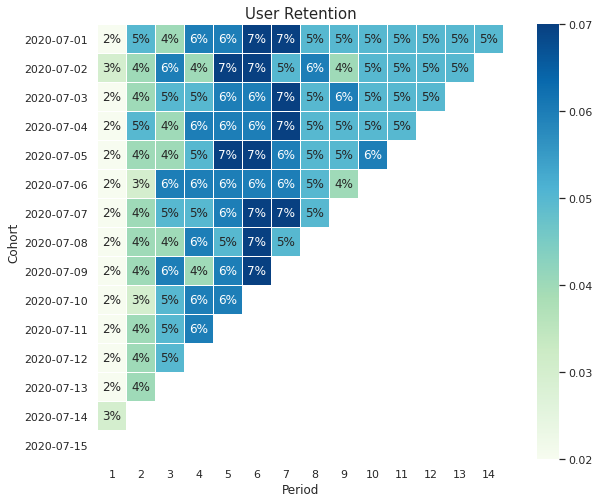

In [61]:
# Воспользуемся функцией рассчета retention игроков за период две недели от даты регистрации пользователей. 
# Выбор дат должен быть из указанного выше интервала, включая его крайние значения. 
retention_funс(reg, auth, '2020-07-01', '2020-07-15')

### Задание 2

***Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.***

***Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?***

Выгрузим данные с Яндекс.Диска.

In [104]:
experiment = YandexDisk_read_csv('https://disk.yandex.com.am/d/quNPpN-zsheT0A', sep = ';')

**1.1. Предварительный анализ данных (EDA)**

In [105]:
experiment.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
# Проверим число пользователей по группам. 
experiment.groupby(['testgroup']).agg({'user_id': 'nunique'})

,user_id
testgroup,
a,202103
b,202667


Следовательно, опираясь на условие задачи, получаем группа a - контрольная группа, а группа b - тестовая. Обновим наименование групп для удобства. 

In [20]:
# Переименуем группы.
experiment['testgroup'].replace({'a': 'control', 'b': 'test'}, inplace = True)

In [21]:
experiment.head()

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test


In [22]:
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [23]:
experiment.duplicated().sum()

0

In [24]:
# Проверим на уникальность пользователей.
experiment.user_id.value_counts().unique()

array([1])

В датасете дубликаты отсутствуют, типы данных корректны, пропусков нет, пользователи уникальны, пересечений по группам нет.

Для того, чтобы оценить результаты A/B теста (выбрать метрики, определить какое предложение будет лучше), необходимо понять с какой целью он был проведен, какую основную идею преследовал бизнес, обращаясь к данному эксперименту. Конкретной информации нет, поэтому попробуем выяснить её самостоятельно посредством анализа представленных данных.

In [25]:
# Посмотрим на статистическую сводку для колонки с доходом в разрезе групп по пользователям.
experiment.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
test,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Можно отметить, что среднее значение по группам практически не отличается (в тестовой больше всего на 5%), но стандартное отклонение в контрольной группе в 3-4 раза большем, что говорит о большем разбросе значений. Max в контрольной группе значительно больше (практически в 10 раз). 

In [26]:
# Посмотрим на статистическую сводку для колонки с доходом в разрезе групп по клиентам (платящим пользователям).
experiment.query('revenue > 0').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Теперь мы видим, что количество людей в тестовой группе стало меньше, чем в контрольной; среднее  стало выше на 11%; остальные статистики, кроме max, в тестовой группе стали в 10-15 раз больше. Max значение в контрольной группе по прежнему значительно превышает max в тестовой. 

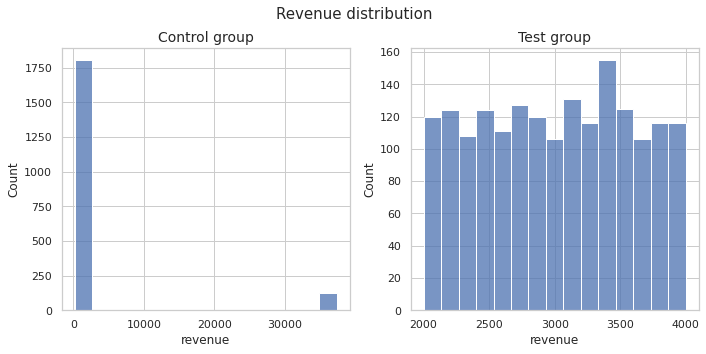

In [27]:
# Посмотрим на визуальную картину распределения выручки платящих пользователей.
fig, axes = plt.subplots(nrows= 1, ncols = 2, figsize = (10, 5))
sns.histplot(experiment.query('revenue > 0 & testgroup == "control"'), x = 'revenue', bins = 15, ax = axes[0])
sns.histplot(experiment.query('revenue > 0 & testgroup == "test"'), x = 'revenue', bins = 15, ax = axes[1])
fig.suptitle('Revenue distribution', fontsize = 15)
axes[0].set_title('Control group', fontsize = 14)
axes[1].set_title('Test group', fontsize = 14)
fig.tight_layout(rect=[0, 0, 1, 0.95])

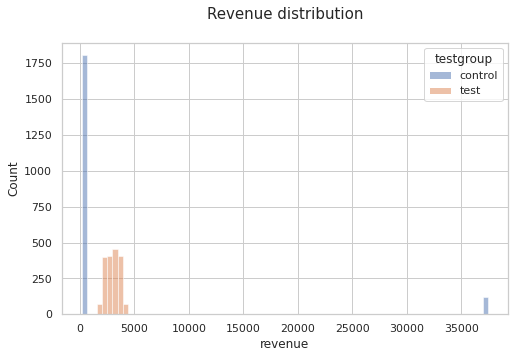

In [28]:
# Визуализируем ту же информацию, но представим её на одном графике.
plt.figure(figsize = (8 ,5))
sns.histplot(experiment.query('revenue > 0'), x = 'revenue', hue = 'testgroup', bins = 80)
plt.title('Revenue distribution\n', fontsize = 15)
plt.show()

Видим, что в тестовой группе распределение выручки по клиентам стремится к равномерному. А в контрольной группе распределение представляет собой биномиальное. Значит в контрольной группе можно выделить две подгруппы клиентов: одна - это клиенты, которые платят очень мало, другая - клиенты, которые оплачивают дорогостоящие предложения. Причем таких высокодоходных клиентов значительно меньше. Определим долю высодоходных клиентов в контрольной группе и их вклад в общую сумму выручки.  

In [29]:
paying_percent = '{:.0f}%'.format(experiment.query('revenue > 35000')['user_id'].nunique() \
                                / experiment.query('revenue > 0  & testgroup == "control"')['user_id'].nunique() \
                                * 100)
revenue_percent = '{:.0f}%'.format(experiment.query('revenue > 35000 ')['revenue'].sum() \
                                 / experiment.query('revenue > 0 & testgroup == "control"')['revenue'].sum() \
                                 * 100)
print(f'Доля высокодоходных клиентов:{paying_percent}\nДоля выручки от них:{revenue_percent}')

Доля высокодоходных клиентов:6%
Доля выручки от них:89%


Таких клиентов в контрольной группе всего 6%. Но зависимость от них велика. Выручка от них составляет 89% от всей выручки по группе. 

А теперь исключим этих клиентов из контрольной группы и сравним основные статистики и распределение выручки по группам.

In [30]:
# Выделим сэмпл клиентов из контрольной группы, исключив высокодоходных, т.е. тех, 
# которые оплачивают предложения стоимостью свыше 35 000 у.е.
sample = experiment.query('0 < revenue < 4000 & testgroup == "control"')

In [31]:
# Сформируем таблицу с основными статистическими данными для обновленной контрольной группы.
control_describe = sample[['revenue']].describe().rename(columns = {'revenue': 'control_sample'})

In [32]:
# Сформируем таблицу с основными статистическими данными для тестовой группы.
test_describe = experiment.query('revenue > 0 & testgroup == "test"')[['revenue']] \
                          .describe().rename(columns = {'revenue': 'test'})

In [33]:
# Соединим две таблицы и сравним показатели.
pd.concat([control_describe, test_describe], axis = 1)

,control_sample,test
count,1805.000000,1805.000000
mean,302.458172,3003.658172
std,57.914246,572.619709
min,200.000000,2000.000000
25%,254.000000,2513.000000
50%,305.000000,3022.000000
75%,352.000000,3478.000000
max,400.000000,4000.000000


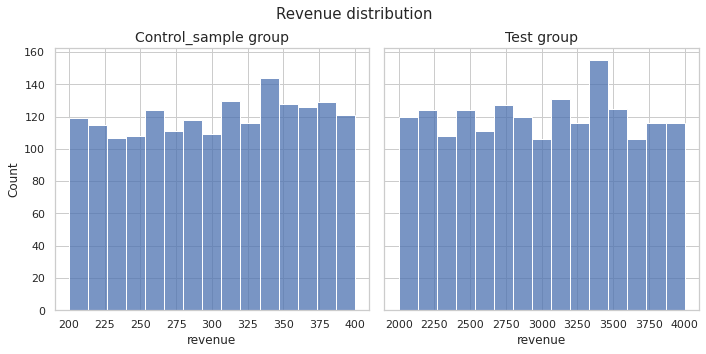

In [34]:
# Визуализируем распределение выручки по группам control_sample и test.
fig, axes = plt.subplots(nrows= 1, ncols = 2, figsize = (10, 5), sharey=True)
sns.histplot(sample, x = 'revenue', bins = 15, ax = axes[0])
sns.histplot(experiment.query('revenue > 0 & testgroup == "test"'), x = 'revenue', bins = 15, ax = axes[1])
fig.suptitle('Revenue distribution', fontsize = 15)
axes[0].set_title('Control_sample group', fontsize = 14)
axes[1].set_title('Test group', fontsize = 14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
#fig.tight_layout()

В новой контрольной и тестовой группах число клиентов одинаково. Но ключевые статистики в тестовой группе в 10 раз больше, чем в контрольной. А теперь можно сделать предположение о смысловой нагрузке эксперимента. Получается, что для контрольной группы было представлено такое аукционное предложение, которое позволило привлечь два типа клиентов: множество низкодоходных клиентов и небольшую долю высокодоходных. А для тестовой группы - такое предложение, которое исключает привлечение высокодоходных клиентов (т.к. клиентов, готовых платить крупные суммы, больше нет, то вероятно и предложений уже таких нет), но в тоже время дает альтернативу взамен прежних дешевых предложений (а может быть это те же самые предложения с большей стоимостью),  повышая стоимость альтернативы в 10 раз. И предварительная оценка показала, что число клиентов из доходной зоны [200 у.е; 400 у.е.] удалось переместить в доходную зону [2000 у.е; 4000 у.е.], но при этом больше клиентов не стало и часть высокодоходных клиентов утеряна. Гипотезу к бизнес-задаче можно сформулировать так: возможно ли повысив стоимость дешевых предложений в 10 раз (или дав альтернативу), убрать предложения для высокодоходных клиентов, чтобы при этом получить значимый эффект и исключить зависимость от высокодоходных клиентов, если вдруг конъюнктура игровой индустрии измениться? 

**1.2. Выбор метрик и статистических методов для анализа результатов экперимента.**

Для дальнейшего анализа будем брать три взаимосвязанные между собой метрики: конверсия (CR), средний доход с привлеченного пользователя (ARPU), средний доход на одного платящего пользователя (клиента) (ARPPU).

Сформируем таблицу метрик.

In [35]:
# Создадим копию исходных данных.
metrics = experiment.copy()

In [36]:
# Добавляем столбцы с метриками.
metrics = metrics.groupby('testgroup') \
                 .agg({'revenue': [lambda x: round((x != 0).sum() / x.count() * 100, 2), 
                                   lambda x: round(x.mean(), 2), 
                                   lambda x: round(x[x>0].mean(), 2)]}) \
                  .rename(columns = {'revenue': '', 
                                     '<lambda_0>': 'CR', 
                                     '<lambda_1>': 'ARPU', 
                                     '<lambda_2>': 'ARPPU'})

In [37]:
# В таблицу с целевыми метриками добавим строку, которая будет отражать отклонения метрик по группам в %.
metrics.loc['delta%'] = ((metrics.loc['test'] - metrics.loc['control']) / metrics.loc[['test','control']].max() *100).round(2)

In [38]:
# Меняем формат вывода отклонений (добавляем знак перед числовым значением).
metrics.loc['delta%'] = metrics.loc['delta%'].apply(lambda x: '{:+g}'.format(x))

In [39]:
metrics

CR   ARPU    ARPPU
testgroup                       
control     0.95  25.41     2664
test        0.89  26.75  3003.66
delta%     -6.32  +5.01   +11.31

По итогу эксперимента в конверсии состоялась потеря 6% клиентов. Есть все основание полагать, что это и есть высокодоходные клиенты. Но при этом мы получили рост метрик среднего дохода. ARPU вырос на 5%, что соответствует условию задачи; ARPPU - на 11%. 

Проверим статистическую значимость наблюдаемых изменений в целевых метриках.

Исходя из правила ЦПТ для ARPU и ARPPU будем использовать t-тест.<br>
ЦПТ гласит, что при достаточно большом размере выборки, распределение средних значений выборочных данных будет приближаться к нормальному распределению, независимо от формы распределения исходной популяции. Выборки у нас большие (число наблюдений > 30), поэтому привязки к нормальному распределению для revenue можно не придерживаться.<br>
Никаких предположений о равных дисперсиях делать не будем. Есть обоснование к этому. Формула для расчета степеней свободы для t-критерия Уэлча учитывает разницу между двумя стандартными отклонениями. Однако если две выборки имеют одинаковые стандартные отклонения, то степени свободы для t-критерия Уэлча будут такими же, как и степени свободы для t-критерия Стьюдента.  Вот и получается, что на практике t-критерий Уэлча работает лучше, чем t-критерий Стьюдента, когда размеры выборки и дисперсии между группами не равны, и дает идентичные результаты, когда размеры выборки и дисперсии равны.<br>
t-критерий Уэлча заложен по дефолту в расчете t-критерия в модуле pingouin. Им и воспользуемся.

Сформулируем гипотезы.

<u> для **ARPU** </u> <br>
* H0: ARPU в контрольной и тестовой группах не отличается
* H1: ARPU в контрольной и тестовой группах отличается<br>


при уровне значимости 5%.

In [40]:
# Проверяем статистическую значимость для отклонения ARPU.
pg.ttest(experiment.query('testgroup == "control"').revenue, 
         experiment.query('testgroup == "test"').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


p-value t-теста для ARPU > 0.05, поэтому мы не можем отклонить нулевую гипотезу.

<u> для **ARPPU** </u> <br>
* H0: ARPPU в контрольной и тестовой группах не отличается
* H1: ARPPU в контрольной и тестовой группах отличается<br>


при уровне значимости 5%.

In [41]:
# Проверяем статистическую значимость для отклонения ARPPU.
pg.ttest(experiment.query('testgroup == "control" & revenue > 0').revenue, 
         experiment.query('testgroup == "test"  & revenue > 0').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


p-value t-теста для ARPPU > 0.05, поэтому мы не можем отклонить нулевую гипотезу.

Поскольку **конверсия** это факт того, совершил покупку пользователь или нет, т.е. это категориальная переменная в наборе данных, для её анализа будем использовать критерий хи-квадрат.

Сформулируем гипотезы.

* H0: Конверсия в контрольной и тестовой группах не отличается
* H1: Конверсия в контрольной и тестовой группах отличается<br>


при уровне значимости 5%.

In [42]:
# Создадим копию исходных данных.
maska = experiment.copy()

In [43]:
# Добавим колонку с идентификатором платящего пользователя.
maska = maska.assign(flag_cr = np.where(maska.revenue == 0, 'No', 'Yes'))

In [44]:
maska.tail()

,user_id,revenue,testgroup,flag_cr
404765,404766,0,control,No
404766,404767,0,test,No
404767,404768,231,control,Yes
404768,404769,0,control,No
404769,404770,0,test,No


In [45]:
# Сформируем таблицу сопряженности.
cross_table = pd.crosstab(maska.testgroup, maska.flag_cr)

In [46]:
cross_table

flag_cr,No,Yes
testgroup,,
control,200175,1928
test,200862,1805


In [47]:
# Получим p-value для конверсии при помощи критерия хи-квадрат.
chi2_contingency(cross_table)[1]

0.03647561892312613

p-value < 0.05, следовательно мы отклоняем нулевую гипотезу. А это значит, что различия по группам в конверсии имеют статистическую значимость. 

Общий <u>вывод</u>: проверка результатов данного эксперимента статистическими методами показала, что потеряв высокодоходных клиентов, бизнес не сможет восполнить потерю в доходе новым предложением, а перспектив получить большую выгоду тем более нет. Прирост в ARPU и ARPPU не имели статистической значимости. Поэтому считать лучшим можно набор аукционных предложений в контрольной группе. 

### Задание 1

***В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?***

***Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?.***

**3.1 Метрики для оценки результатов последнего прошедшего события.**

1. Оценка частоты использования события:
   * Средняя дневная аудитория за тот период, в течении которого проводилось событие / Число уникальных пользователей, которые зашли в игру во время проведения события. Если событие вызывает интерес у аудитории, то показатель должен быть выше, чем в аналогичный обычный период, когда не проводится никаких мероприятий. 
   * Средняя дневная аудитория за месяц / MAU. Позволит оценить интерес игроков к различным событиям. Можно будет ранжировать события на основании интереса игроков к ним. 
2. Среднее время прохождения всех уровней. 
3. Retention Rate. Удержание игроков даст оценку успешности игры. Он определяет, как долго игроки остаются в игре и продолжают играть после первого запуска. Чем выше уровень удержания, тем лучше.
4. Churn Rate. Отказы игроков от игры позволяют определить, сколько игроков покидает игру после определенного периода времени или после определенного уровня. Чем ниже отказы, тем лучше. 
5. Среднее число уровней, которые удается пройти игрокам за отведенное время.
6. Среднее число наград на одного игрока общее и по категориям. 
7. Если событие предполагает покупки, то можно оценить и доходные метрики (ARPU, ARPPU, средний чек)

**3.2 Метрики для оценки результатов тематического события с усложненной механикой.**

К уже указанным метрикам оценки результатов последнего прошедшего события нужно добавить:
1. Среднее число откатов для каждого уровня.
2. Критическое значение откатов (При котором значение Churn Rate наибольшее).